the below code equally partitions no tumor and then sets alpha as 1



In [1]:
import os
import random
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Subset, random_split


# ---- CONFIG ----
ROOT = "/Users/ishabhansali/Downloads/resnet_project/cleaned"
TRAIN_DIR = os.path.join(ROOT, "Training")
TEST_DIR = os.path.join(ROOT, "Testing")
NUM_CLIENTS = 4
LOCAL_TEST_FRAC = 0.2
SEED = 77
ALPHA = 0.3 # Moderate non-IID
BATCH_SIZE_MOD = 32

def set_seed(s=SEED):
    random.seed(s)
    np.random.seed(s)
    torch.manual_seed(s)
    torch.cuda.manual_seed_all(s)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed()

# ---- PATH CHECKS ----
if not os.path.exists(ROOT):
    raise FileNotFoundError(f"ROOT folder not found: {ROOT}")
if not os.path.exists(TRAIN_DIR):
    raise FileNotFoundError(f"Training directory not found: {TRAIN_DIR}")
if not os.path.exists(TEST_DIR):
    raise FileNotFoundError(f"Testing directory not found: {TEST_DIR}")

# ---- TRANSFORM AND LOAD ----
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=transform)
print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

print("Creating global holdout (test) loader for moderate non-IID setup...")
holdout_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE_MOD,
    shuffle=False,
    num_workers=0
)
print("Global holdout samples:", len(test_dataset))

# ---- MODERATE NON-IID PARTITION (DIRICHLET) ----
labels = np.array([sample[1] for sample in train_dataset])
num_classes = len(train_dataset.classes)
class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

client_indices = [[] for _ in range(NUM_CLIENTS)]
np.random.seed(SEED)

for c, idxs in enumerate(class_indices):
    # Sample proportions for each client using Dirichlet
    proportions = np.random.dirichlet(np.repeat(ALPHA, NUM_CLIENTS))
    # Adjust for rounding errors
    proportions = (np.cumsum(proportions) * len(idxs)).astype(int)[:-1]
    split_idxs = np.split(np.random.permutation(idxs), proportions)
    for client, idx in enumerate(split_idxs):
        client_indices[client].extend(idx)

# Shuffle indices for each client, then create subsets
client_subsets = []
for indices in client_indices:
    indices = np.array(indices)
    np.random.shuffle(indices)
    subset = torch.utils.data.Subset(train_dataset, indices.tolist())
    client_subsets.append(subset)
    print(f"Client {len(client_subsets)-1} train samples: {len(subset)}")

# ---- TEST SPLIT FOR EACH CLIENT ----
client_data = []
for c in client_subsets:
    n_test = int(len(c) * LOCAL_TEST_FRAC)
    n_train = len(c) - n_test
    tr, te = random_split(c, [n_train, n_test], generator=torch.Generator().manual_seed(SEED))
    client_data.append((tr, te))
    print(f"Client train: {n_train}, test: {n_test}")

# ---- CLASS BREAKDOWN FOR EACH CLIENT ----
class_names = train_dataset.classes
for idx, (client_train, _) in enumerate(client_data):
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = {class_name: labels.count(i) for i, class_name in enumerate(class_names)}
    print(f"Client {idx}:")
    for class_name in class_names:
        print(f"  {class_name}: {counts[class_name]} samples")
    print("-" * 30)
for idx, (client_train, client_test) in enumerate(client_data):
    # Train split breakdown
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    train_counts = {class_name: train_labels.count(i) for i, class_name in enumerate(class_names)}

    # Test split breakdown
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    test_counts = {class_name: test_labels.count(i) for i, class_name in enumerate(class_names)}

    print(f"Client {idx}:")
    print("  Training set:")
    for class_name in class_names:
        print(f"    {class_name}: {train_counts[class_name]} samples")
    print("  Testing set:")
    for class_name in class_names:
        print(f"    {class_name}: {test_counts[class_name]} samples")
    print("-" * 30)



Train samples: 5712, Test samples: 1311
Creating global holdout (test) loader for moderate non-IID setup...
Global holdout samples: 1311
Client 0 train samples: 1559
Client 1 train samples: 658
Client 2 train samples: 227
Client 3 train samples: 3268
Client train: 1248, test: 311
Client train: 527, test: 131
Client train: 182, test: 45
Client train: 2615, test: 653
Client 0:
  glioma: 1036 samples
  meningioma: 129 samples
  notumor: 83 samples
  pituitary: 0 samples
------------------------------
Client 1:
  glioma: 0 samples
  meningioma: 157 samples
  notumor: 5 samples
  pituitary: 365 samples
------------------------------
Client 2:
  glioma: 16 samples
  meningioma: 0 samples
  notumor: 166 samples
  pituitary: 0 samples
------------------------------
Client 3:
  glioma: 7 samples
  meningioma: 787 samples
  notumor: 1037 samples
  pituitary: 784 samples
------------------------------
Client 0:
  Training set:
    glioma: 1036 samples
    meningioma: 129 samples
    notumor: 83 s

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(client_subsets, class_names, alpha_value):
    num_clients = len(client_subsets)
    num_classes = len(class_names)

    # Count per-class samples for each client
    dist_matrix = np.zeros((num_clients, num_classes), dtype=int)

    for client_id, subset in enumerate(client_subsets):
        labels = [subset[i][1] for i in range(len(subset))]
        for cls in range(num_classes):
            dist_matrix[client_id, cls] = labels.count(cls)

    # ----------- Plot Bar Chart -----------
    x = np.arange(num_clients)
    width = 0.2   # width of each bar

    plt.figure(figsize=(10,5))
    
    for cls in range(num_classes):
        plt.bar(x + cls*width, dist_matrix[:, cls], width, label=class_names[cls])

    plt.xticks(x + width, [f"client_{i}" for i in range(num_clients)])
    plt.ylabel("Number of Images")
    plt.title(f"Class Distribution (Dirichlet α = {alpha_value})")
    plt.legend()
    plt.grid(axis='y', alpha=0.3)

    plt.show()

    return dist_matrix


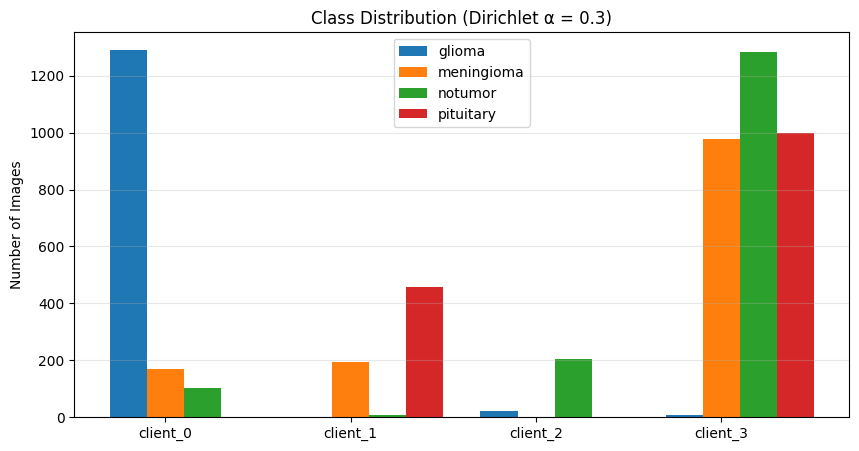

In [5]:
dist_mod = plot_class_distribution(client_subsets, class_names, alpha_value=0.3)


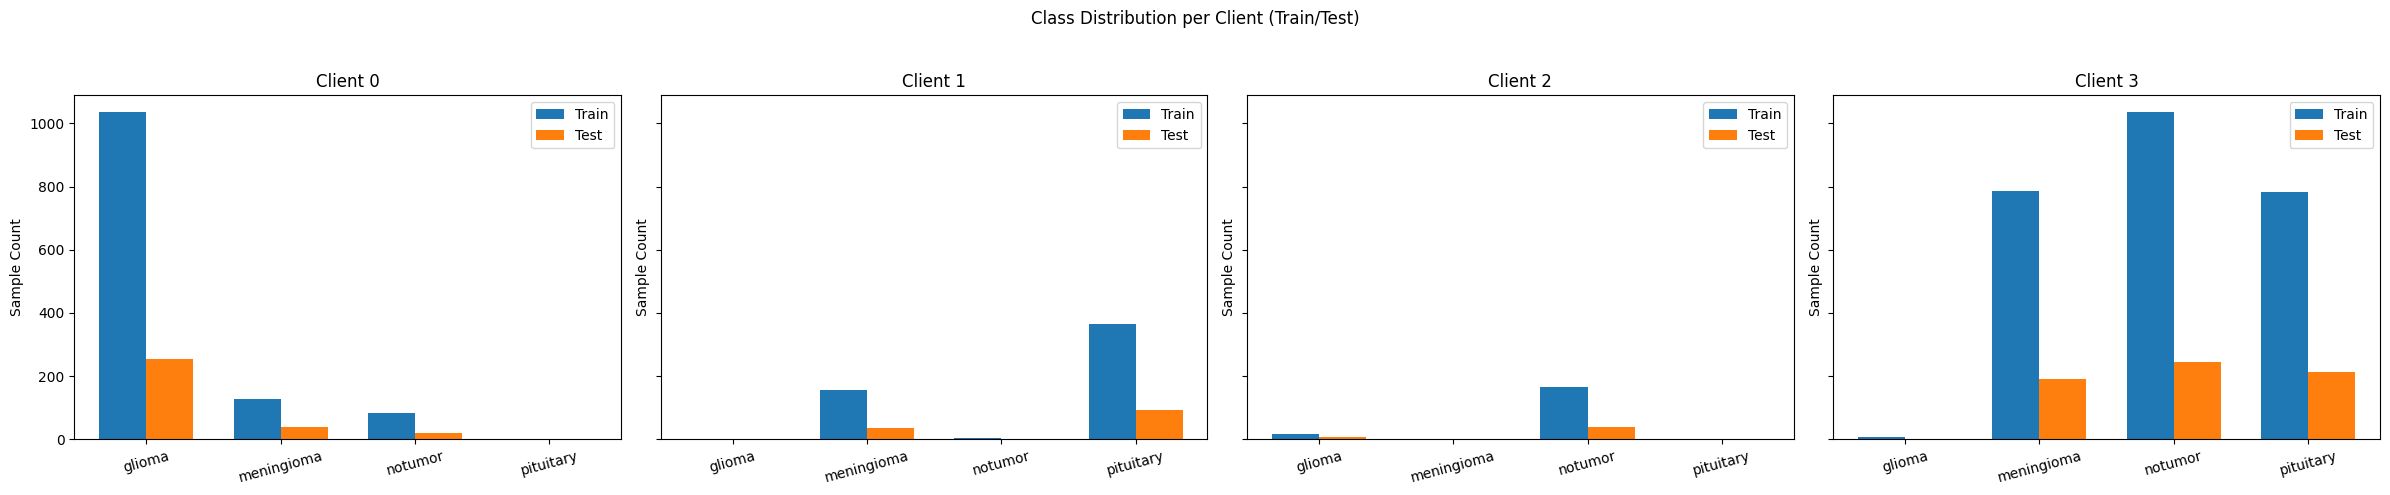

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# ---- PREPARE DATA FOR PLOTTING ----
client_train_counts = []
client_test_counts = []

for idx, (client_train, client_test) in enumerate(client_data):
    train_labels = [client_train[i][1] for i in range(len(client_train))]
    test_labels = [client_test[i][1] for i in range(len(client_test))]
    train_counts = [train_labels.count(i) for i in range(len(class_names))]
    test_counts = [test_labels.count(i) for i in range(len(class_names))]
    client_train_counts.append(train_counts)
    client_test_counts.append(test_counts)

client_train_counts = np.array(client_train_counts)
client_test_counts = np.array(client_test_counts)

# ---- GROUPED BAR CHART FOR EACH CLIENT ----
num_classes = len(class_names)
num_clients = len(client_data)
x = np.arange(num_classes)  # the label locations

fig, axs = plt.subplots(1, num_clients, figsize=(6 * num_clients, 5), sharey=True)
# Each subplot is for one client
for idx in range(num_clients):
    width = 0.35
    axs[idx].bar(x - width/2, client_train_counts[idx], width, label='Train', color='tab:blue')
    axs[idx].bar(x + width/2, client_test_counts[idx], width, label='Test', color='tab:orange')
    axs[idx].set_xticks(x)
    axs[idx].set_xticklabels(class_names, rotation=15)
    axs[idx].set_ylabel('Sample Count')
    axs[idx].set_title(f'Client {idx}')
    axs[idx].legend()

plt.suptitle('Class Distribution per Client (Train/Test)')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


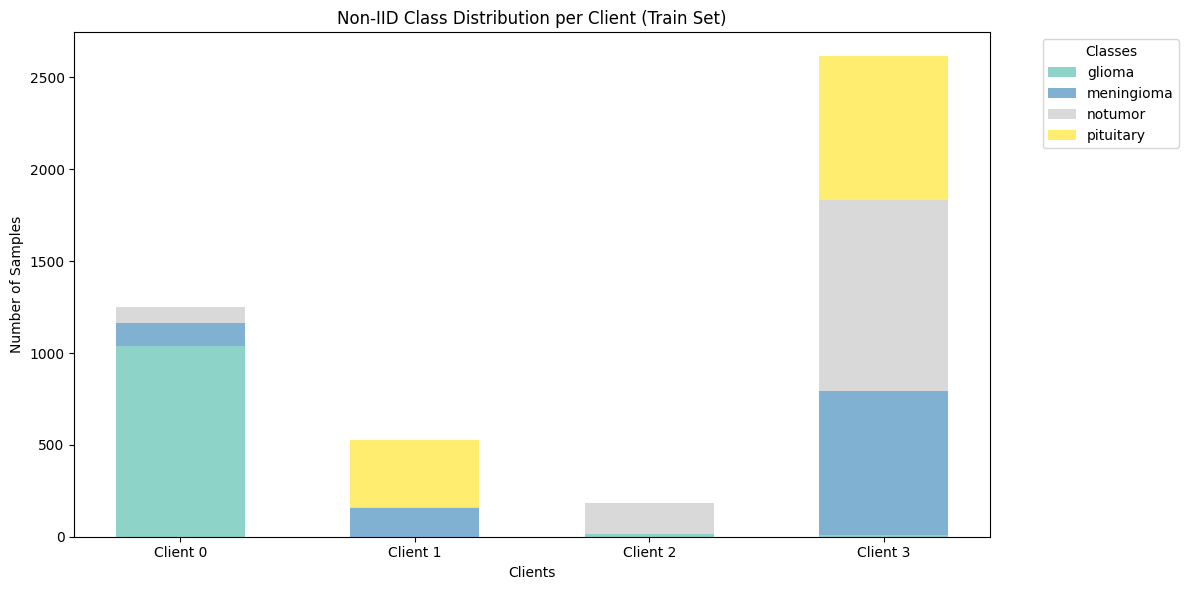

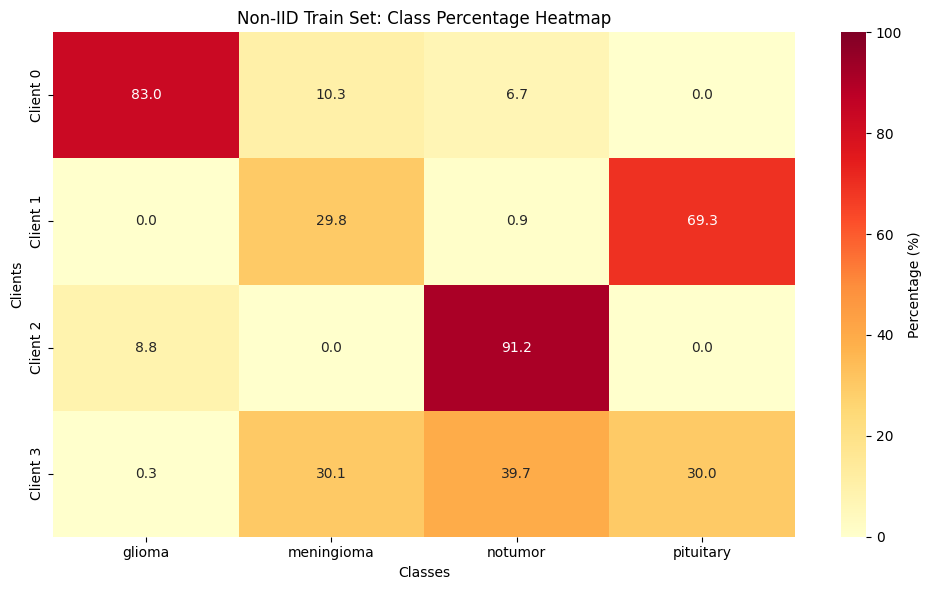

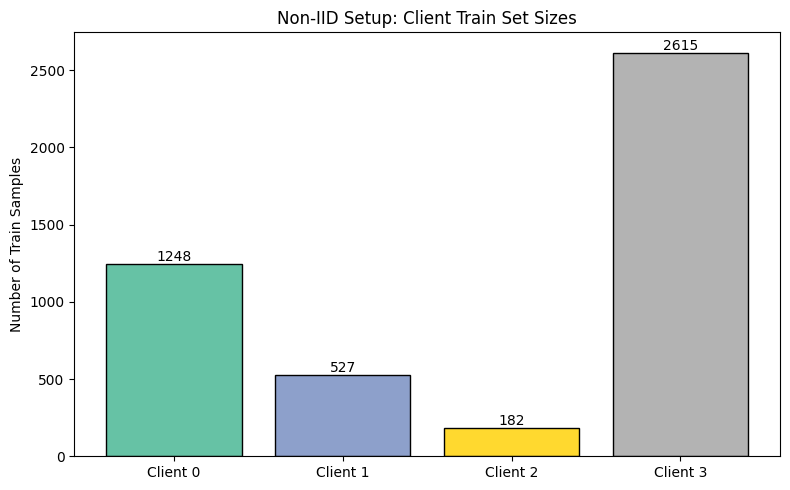

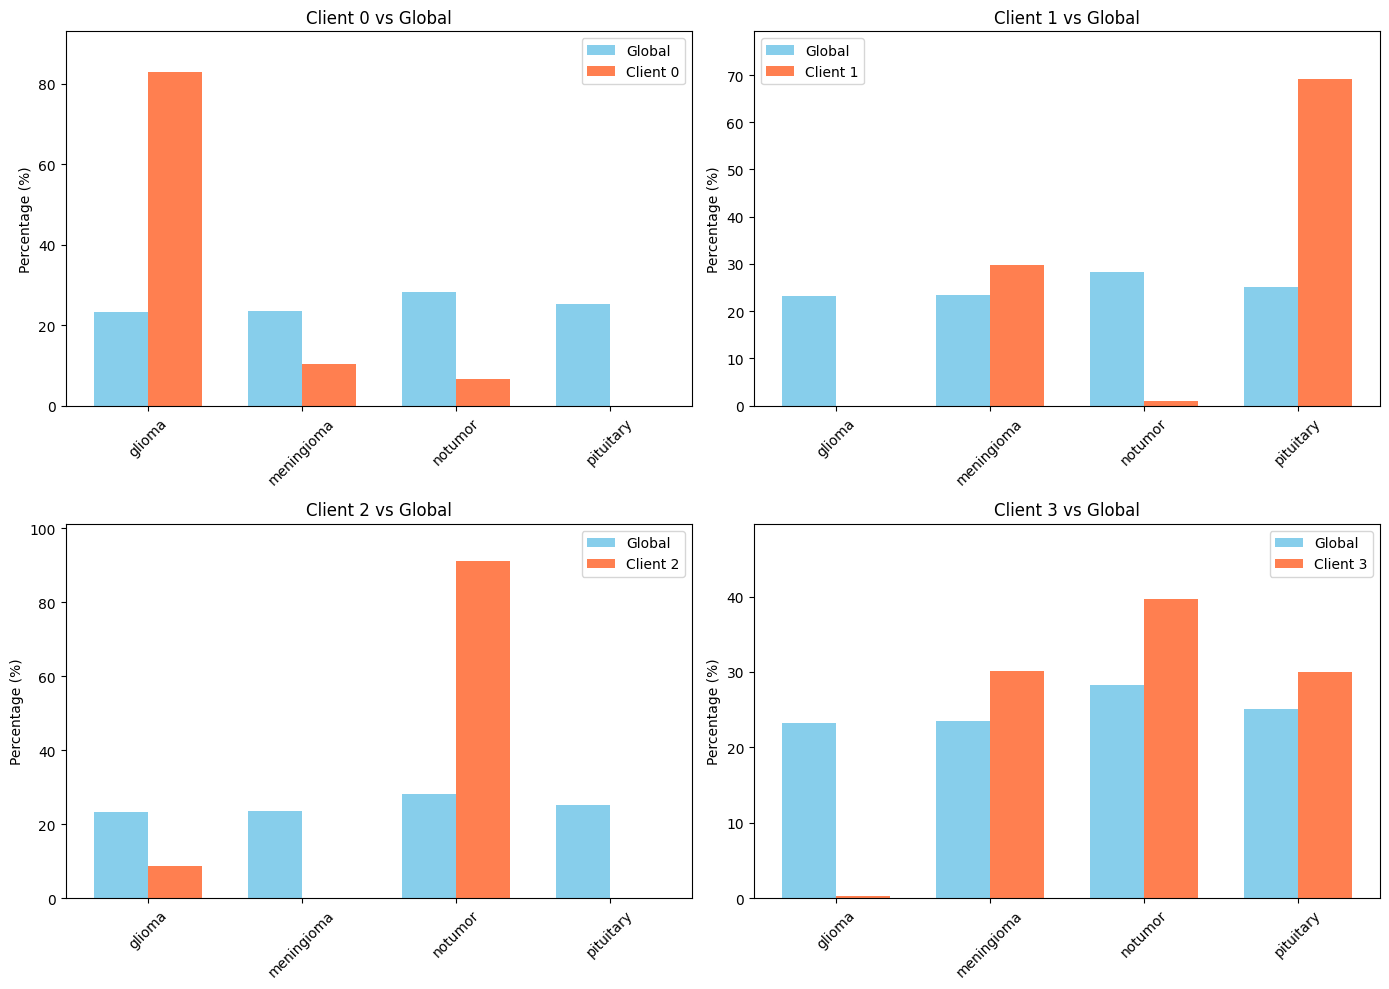


NON-IID DATA DISTRIBUTION SUMMARY (Train)

Client 0: 1248 samples
  glioma: 1036 (83.0%)
  meningioma: 129 (10.3%)
  notumor: 83 (6.7%)
  pituitary: 0 (0.0%)

Client 1: 527 samples
  glioma: 0 (0.0%)
  meningioma: 157 (29.8%)
  notumor: 5 (0.9%)
  pituitary: 365 (69.3%)

Client 2: 182 samples
  glioma: 16 (8.8%)
  meningioma: 0 (0.0%)
  notumor: 166 (91.2%)
  pituitary: 0 (0.0%)

Client 3: 2615 samples
  glioma: 7 (0.3%)
  meningioma: 787 (30.1%)
  notumor: 1037 (39.7%)
  pituitary: 784 (30.0%)

Global Distribution (Train Set):
  glioma: 1059 (23.2%)
  meningioma: 1073 (23.5%)
  notumor: 1291 (28.2%)
  pituitary: 1149 (25.1%)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict

# ----- 1. Collect train set class counts for each client -----
client_class_dist = []
for client_train, _ in client_data:  # only train split
    labels = [client_train[i][1] for i in range(len(client_train))]
    counts = [labels.count(i) for i in range(len(class_names))]
    client_class_dist.append(counts)

num_clients = len(client_class_dist)
num_classes = len(class_names)

# ----- 2. Stacked bar chart: class samples per client -----
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(num_clients)
bottom = np.zeros(num_clients)
colors = plt.cm.Set3(np.linspace(0, 1, num_classes))

for class_idx in range(num_classes):
    values = [client_class_dist[cidx][class_idx] for cidx in range(num_clients)]
    ax.bar(x, values, bottom=bottom, width=0.55, color=colors[class_idx], label=class_names[class_idx])
    bottom += np.array(values)
ax.set_xticks(x)
ax.set_xticklabels([f"Client {i}" for i in range(num_clients)])
ax.set_ylabel("Number of Samples")
ax.set_xlabel("Clients")
ax.set_title("Non-IID Class Distribution per Client (Train Set)")
ax.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ----- 3. Heatmap: class percentage per client -----
heatmap_data = []
for counts in client_class_dist:
    total = sum(counts)
    row = [100 * c / total if total > 0 else 0 for c in counts]
    heatmap_data.append(row)
heatmap_data = np.array(heatmap_data)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Percentage (%)'},
            xticklabels=class_names, yticklabels=[f"Client {i}" for i in range(num_clients)], ax=ax, vmin=0, vmax=100)
ax.set_title("Non-IID Train Set: Class Percentage Heatmap")
ax.set_xlabel("Classes")
ax.set_ylabel("Clients")
plt.tight_layout()
plt.show()

# ----- 4. Bar chart: client train set sizes -----
client_sizes = [sum(counts) for counts in client_class_dist]
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar([f"Client {i}" for i in range(num_clients)], client_sizes, color=plt.cm.Set2(np.linspace(0,1,num_clients)), edgecolor='black')
ax.set_ylabel("Number of Train Samples")
ax.set_title("Non-IID Setup: Client Train Set Sizes")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{int(height)}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ----- 5. Comparison: global distribution vs client -----
global_counts = [0 for _ in range(num_classes)]
for client_train, _ in client_data:
    labels = [client_train[i][1] for i in range(len(client_train))]
    for i in labels:
        global_counts[i] += 1
global_total = sum(global_counts)
global_percentages = [100 * c / global_total for c in global_counts]

fig, axes = plt.subplots(2, (num_clients+1)//2, figsize=(14, 10))
axes = axes.flatten()
for idx in range(num_clients):
    client_total = sum(client_class_dist[idx])
    client_percentages = [100 * n / client_total if client_total > 0 else 0 for n in client_class_dist[idx]]
    x_pos = np.arange(num_classes)
    width = 0.35
    axes[idx].bar(x_pos - width/2, global_percentages, width, label='Global', color='skyblue')
    axes[idx].bar(x_pos + width/2, client_percentages, width, label=f'Client {idx}', color='coral')
    axes[idx].set_title(f"Client {idx} vs Global")
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels(class_names, rotation=45)
    axes[idx].set_ylabel("Percentage (%)")
    axes[idx].legend()
    axes[idx].set_ylim([0, max(global_percentages + client_percentages) + 10])
plt.tight_layout()
plt.show()

# ----- 6. Summary statistics -----
print("\n" + "="*50)
print("NON-IID DATA DISTRIBUTION SUMMARY (Train)")
print("="*50)
for idx, counts in enumerate(client_class_dist):
    client_total = sum(counts)
    print(f"\nClient {idx}: {client_total} samples")
    for class_idx, class_name in enumerate(class_names):
        pct = 100 * counts[class_idx] / client_total if client_total > 0 else 0
        print(f"  {class_name}: {counts[class_idx]} ({pct:.1f}%)")

print("\n" + "="*50)
print("Global Distribution (Train Set):")
print("="*50)
for class_idx, class_name in enumerate(class_names):
    pct = 100 * global_counts[class_idx] / global_total if global_total > 0 else 0
    print(f"  {class_name}: {global_counts[class_idx]} ({pct:.1f}%)")
print("="*50)


In [8]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# ----- 1. Prepare class distributions -----

# Get number of classes
num_classes = len(train_dataset.classes)

# Extract class distributions for each client
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]  # (filename, class_idx)
        counts[class_idx] += 1
    # Normalize to probabilities
    if counts.sum() > 0:
        prob_vec = counts / counts.sum()
    else:
        prob_vec = counts
    client_distributions.append(prob_vec)

# ----- 2. Compute global class distribution -----
global_counts = np.zeros(num_classes)
for sample in train_dataset.samples:
    class_idx = sample[1]
    global_counts[class_idx] += 1
global_dist = global_counts / global_counts.sum()

print("Global Distribution:", global_dist)
print("Classes:", train_dataset.classes)

# ----- 3. Compute Jensen-Shannon Divergence (JS Divergence) -----
print("\n" + "="*70)
print("JENSEN-SHANNON DIVERGENCE (Client vs Global)")
print("="*70)
print("Range: 0 (identical) to 1 (completely different)\n")

js_divergences = []
for k, client_dist in enumerate(client_distributions):
    js_div = jensenshannon(global_dist, client_dist)
    js_divergences.append(js_div)
    print(f"Client {k}: JS Divergence = {js_div:.4f}")

avg_js = np.mean(js_divergences)
print(f"\nAverage JS Divergence: {avg_js:.4f}")


Global Distribution: [0.23126751 0.23441877 0.27923669 0.25507703]
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']

JENSEN-SHANNON DIVERGENCE (Client vs Global)
Range: 0 (identical) to 1 (completely different)

Client 0: JS Divergence = 0.4744
Client 1: JS Divergence = 0.4636
Client 2: JS Divergence = 0.5180
Client 3: JS Divergence = 0.2855

Average JS Divergence: 0.4354


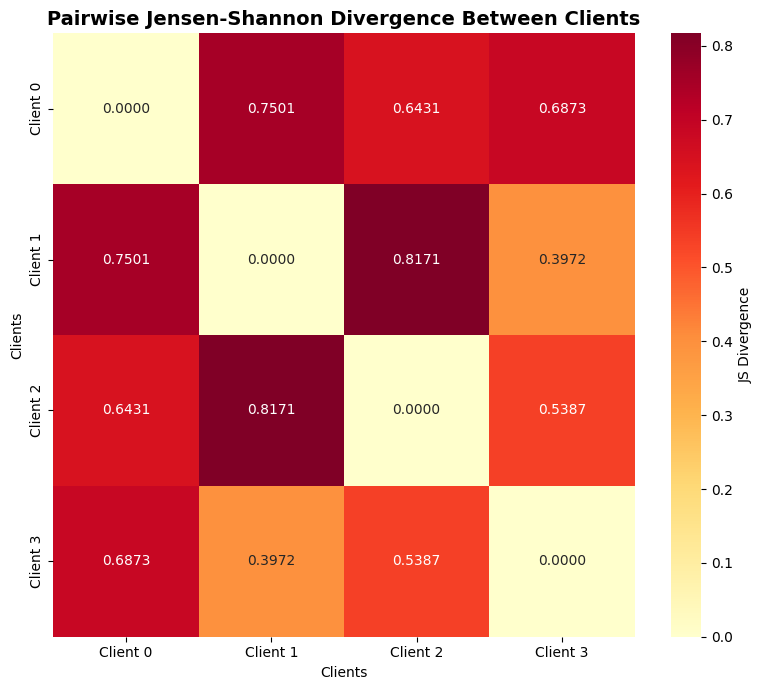

In [9]:
import numpy as np
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import seaborn as sns

# ----- 1. Prepare client class probability distributions -----
num_classes = len(train_dataset.classes)
client_distributions = []
for k in range(NUM_CLIENTS):
    idxs = client_indices[k]
    counts = np.zeros(num_classes)
    for i in idxs:
        class_idx = train_dataset.samples[i][1]
        counts[class_idx] += 1
    prob_vec = counts / counts.sum() if counts.sum() > 0 else counts
    client_distributions.append(prob_vec)

# ----- 2. Compute pairwise JS divergence matrix -----
pairwise_js = np.zeros((NUM_CLIENTS, NUM_CLIENTS))
for i in range(NUM_CLIENTS):
    for j in range(NUM_CLIENTS):
        pairwise_js[i, j] = jensenshannon(client_distributions[i], client_distributions[j])

# ----- 3. Plot pairwise JS divergence heatmap -----
plt.figure(figsize=(8, 7))
sns.heatmap(pairwise_js, annot=True, fmt='.4f', cmap='YlOrRd',
            xticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            yticklabels=[f'Client {i}' for i in range(NUM_CLIENTS)],
            cbar_kws={'label': 'JS Divergence'})
plt.title('Pairwise Jensen-Shannon Divergence Between Clients', fontsize=14, fontweight='bold')
plt.xlabel('Clients')
plt.ylabel('Clients')
plt.tight_layout()
plt.show()


In [15]:
# ============================================================
#                    FEDAVG (MODERATE NON-IID)
#        Clean Version With Renamed Variables + Paths
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
import numpy as np
from torch.utils.data import DataLoader, Subset, random_split


# ============================================================
#                  DEVICE
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)

# ============================================================
#        CONFIG (MODERATE NON-IID EXPERIMENT VERSION)
# ============================================================
SEED = 77
NUM_ROUNDS_MOD = 20
LOCAL_EPOCHS_MOD = 2
LR_MOD = 1e-4

NUM_CLIENTS_MOD = len(client_data)     # client_data from your Dirichlet code
NUM_CLASSES_MOD = len(train_dataset.classes)

# ============================================================
#               SET RANDOM SEED
# ============================================================
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce = nn.CrossEntropyLoss()

# ============================================================
#                    MODEL BUILDER
# ============================================================
def create_resnet18_mod(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model


# ============================================================
#                TRAINING FUNCTIONS
# ============================================================
def train_one_epoch_mod(model, loader, device, optimizer):
    model.train()
    total_loss, total_correct, total = 0, 0, 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        loss = crit_ce(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / total, "acc": total_correct / total}


@torch.no_grad()
def evaluate_mod(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / total, "acc": total_correct / total}


# ============================================================
#             BUILD CLIENT LOADERS (IN MEMORY)
# ============================================================
client_train_loaders_mod = []
client_test_loaders_mod = []

for (train_subset, test_subset) in client_data:
    client_train_loaders_mod.append(DataLoader(train_subset, batch_size=32, shuffle=True))
    client_test_loaders_mod.append(DataLoader(test_subset, batch_size=32, shuffle=False))


# ============================================================
#                  GLOBAL MODEL INIT
# ============================================================
global_model_mod = create_resnet18_mod(NUM_CLASSES_MOD).to(DEVICE)

best_acc_mod = -1
best_state_mod = None

# This history is NEW and will NOT collide with extreme non-IID
metrics_history_mod = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS_MOD)}
}

# ============================================================
#                  FEDAVG TRAINING LOOP
# ============================================================
for rnd in range(NUM_ROUNDS_MOD):
    print(f"\n🔁 [MOD-NONIID] FedAvg Round {rnd+1}/{NUM_ROUNDS_MOD}")
    local_states = []

    # ---------- LOCAL TRAIN ----------
    for k in range(NUM_CLIENTS_MOD):
        local_model = copy.deepcopy(global_model_mod).to(DEVICE)
        optimizer = optim.Adam(local_model.parameters(), lr=LR_MOD)

        for ep in range(LOCAL_EPOCHS_MOD):
            train_one_epoch_mod(local_model, client_train_loaders_mod[k], DEVICE, optimizer)

        # Save local model weights
        local_states.append({n: p.cpu() for n, p in local_model.state_dict().items()})

        # Evaluate on its own test set
        client_metric = evaluate_mod(local_model, client_test_loaders_mod[k], DEVICE)
        metrics_history_mod["clients"][k].append(client_metric)

        print(f"  Client {k} | Test Acc: {client_metric['acc']:.4f}")

    # ---------- FEDERATED AVERAGE ----------
    new_state = {}
    for key in global_model_mod.state_dict().keys():
        stacked = torch.stack([local_states[i][key] for i in range(NUM_CLIENTS_MOD)], dim=0)

        if stacked.dtype.is_floating_point:
            new_state[key] = stacked.mean(dim=0)
        else:
            new_state[key] = stacked[0]

    global_model_mod.load_state_dict(new_state)

    # ---------- GLOBAL EVALUATION ----------
    holdout_metric = evaluate_mod(global_model_mod, holdout_loader, DEVICE)

    metrics_history_mod["round"].append(rnd + 1)
    metrics_history_mod["holdout"].append(holdout_metric)

    print(f"🌍 Global Holdout Acc: {holdout_metric['acc']:.4f}, Loss: {holdout_metric['loss']:.4f}")

    # ---------- SAVE BEST ----------
    if holdout_metric["acc"] > best_acc_mod:
        best_acc_mod = holdout_metric["acc"]
        best_state_mod = copy.deepcopy(global_model_mod.state_dict())
        print(f"💾 Saved NEW BEST (MOD-NONIID) Model: Acc = {best_acc_mod:.4f}")


# ============================================================
#                   SAVE BEST GLOBAL MODEL
# ============================================================
if best_state_mod is not None:
    torch.save(best_state_mod, "best_fedavg_moderate_noniid.pth")
    print("\n✅ Saved: best_fedavg_moderate_noniid.pth")
else:
    print("⚠ No improved model saved.")


Device: mps

🔁 [MOD-NONIID] FedAvg Round 1/20
  Client 0 | Test Acc: 0.9246
  Client 1 | Test Acc: 0.6782
  Client 2 | Test Acc: 0.5494
  Client 3 | Test Acc: 0.5125
🌍 Global Holdout Acc: 0.4218, Loss: 1.5418
💾 Saved NEW BEST (MOD-NONIID) Model: Acc = 0.4218

🔁 [MOD-NONIID] FedAvg Round 2/20
  Client 0 | Test Acc: 0.8618
  Client 1 | Test Acc: 0.7701
  Client 2 | Test Acc: 0.7222
  Client 3 | Test Acc: 0.6750
🌍 Global Holdout Acc: 0.7651, Loss: 0.5839
💾 Saved NEW BEST (MOD-NONIID) Model: Acc = 0.7651

🔁 [MOD-NONIID] FedAvg Round 3/20
  Client 0 | Test Acc: 0.8945
  Client 1 | Test Acc: 0.6667
  Client 2 | Test Acc: 0.6728
  Client 3 | Test Acc: 0.7469
🌍 Global Holdout Acc: 0.7079, Loss: 0.6862

🔁 [MOD-NONIID] FedAvg Round 4/20
  Client 0 | Test Acc: 0.8518
  Client 1 | Test Acc: 0.7893
  Client 2 | Test Acc: 0.7531
  Client 3 | Test Acc: 0.9094
🌍 Global Holdout Acc: 0.8230, Loss: 0.4449
💾 Saved NEW BEST (MOD-NONIID) Model: Acc = 0.8230

🔁 [MOD-NONIID] FedAvg Round 5/20
  Client 0 | Tes

✅ Loaded best FedAvg Moderate Non-IID model!

📊 BEST FedAvg Moderate Non-IID MODEL METRICS
Accuracy:  0.8879
Precision: 0.8818
Recall:    0.8789
F1-score:  0.8788


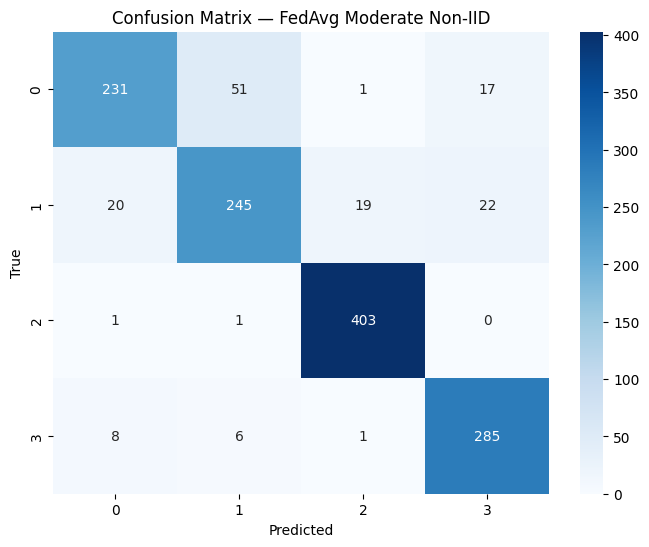

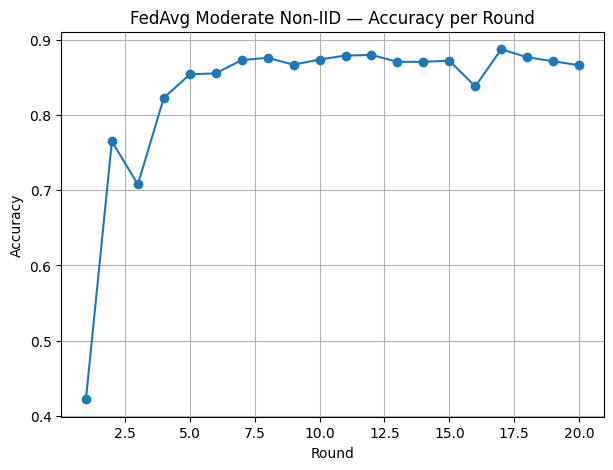

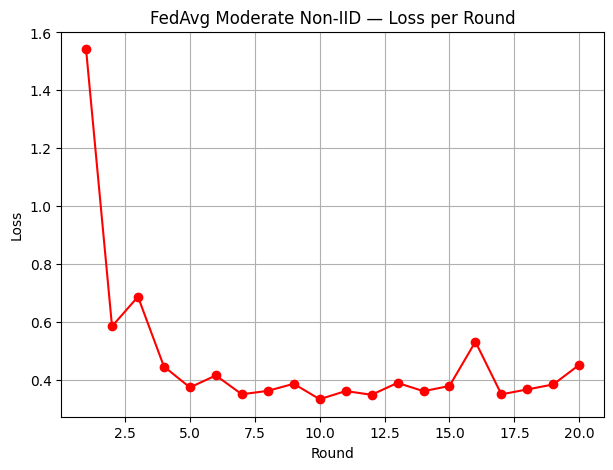

In [19]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
from torchvision import models
import torch.nn as nn

# ===============================
# CONFIG
# ===============================
NUM_CLASSES_MOD = len(train_dataset.classes)

# ===============================
# MODEL DEF
# ===============================
def create_resnet18_mod(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ===============================
# LOAD BEST MODEL
# ===============================
best_model_mod = create_resnet18_mod(NUM_CLASSES_MOD)
best_model_mod.load_state_dict(torch.load("best_fedavg_moderate_noniid.pth"))
best_model_mod.to(DEVICE)
best_model_mod.eval()

print("✅ Loaded best FedAvg Moderate Non-IID model!")

# ===============================
# EVALUATE ON HOLDOUT SET
# ===============================
all_preds = []
all_labels = []

with torch.no_grad():
    for x, y in holdout_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = best_model_mod(x)
        preds = logits.argmax(1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# ---------- METRICS ----------
acc = (all_preds == all_labels).mean()
prec = precision_score(all_labels, all_preds, average="macro")
rec = recall_score(all_labels, all_preds, average="macro")
f1 = f1_score(all_labels, all_preds, average="macro")

print("\n📊 BEST FedAvg Moderate Non-IID MODEL METRICS")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# ===============================
# CONFUSION MATRIX
# ===============================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — FedAvg Moderate Non-IID")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ===============================
# Round-wise accuracy/loss plots
# ===============================
rounds = metrics_history_mod["round"]
accs = [m["acc"] for m in metrics_history_mod["holdout"]]
losses = [m["loss"] for m in metrics_history_mod["holdout"]]

plt.figure(figsize=(7,5))
plt.plot(rounds, accs, marker='o')
plt.title("FedAvg Moderate Non-IID — Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(rounds, losses, marker='o', color="red")
plt.title("FedAvg Moderate Non-IID — Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [21]:
# ============================================================
#              FEDPROX (MODERATE NON-IID VERSION)
#     Clean version with NEW variable names (no overlap)
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
import numpy as np
from torch.utils.data import DataLoader

# ============================================================
#                     DEVICE
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)

# ============================================================
#                     CONFIG
# ============================================================
SEED = 77
NUM_ROUNDS_MODPROX = 20
LOCAL_EPOCHS_MODPROX = 2
LR_MODPROX = 1e-4
FEDPROX_MU_MOD = 1e-4  # recommended default
BATCH_SIZE_MODPROX = 32

NUM_CLIENTS_MODPROX = len(client_data)
NUM_CLASSES_MODPROX = len(train_dataset.classes)

# ============================================================
#                     REPRODUCIBILITY
# ============================================================
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce_mod = nn.CrossEntropyLoss()

# ============================================================
#                   MODEL CREATION
# ============================================================
def create_resnet18_modprox(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ============================================================
#              STANDARD EVALUATION FUNCTION
# ============================================================
@torch.no_grad()
def evaluate_modprox(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce_mod(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / total, "acc": total_correct / total}

# ============================================================
#               FEDPROX LOCAL TRAINING FUNCTION
# ============================================================
def train_fedprox_epoch_mod(model, loader, device, optimizer, global_params, mu):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce_mod(logits, y)

        # ---- FedProx proximal regularizer ----
        prox_term = 0.0
        for name, param in model.named_parameters():
            prox_term += ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / total, "acc": total_correct / total}

# ============================================================
#         CREATE CLIENT TRAIN + TEST LOADERS (MOD-NONIID)
# ============================================================
client_train_loaders_modprox = []
client_test_loaders_modprox = []

for (train_subset, test_subset) in client_data:
    client_train_loaders_modprox.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_MODPROX, shuffle=True)
    )
    client_test_loaders_modprox.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_MODPROX, shuffle=False)
    )

# ============================================================
#         GLOBAL MODEL INIT (MODERATE NON-IID FedProx)
# ============================================================
global_model_modprox = create_resnet18_modprox(NUM_CLASSES_MODPROX).to(DEVICE)

best_acc_modprox = -1
best_state_modprox = None

metrics_history_modprox = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS_MODPROX)}
}

# ============================================================
#                     FEDPROX TRAINING LOOP
# ============================================================
for rnd in range(NUM_ROUNDS_MODPROX):

    print(f"\n🔁 [MOD-NONIID] FedProx Round {rnd+1}/{NUM_ROUNDS_MODPROX}")

    local_states = []

    # Cache global parameters
    global_params_copy = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_modprox.named_parameters()
    }

    # ----------------- CLIENT TRAINING -----------------
    for k in range(NUM_CLIENTS_MODPROX):

        local_model = copy.deepcopy(global_model_modprox).to(DEVICE)
        optimizer = optim.Adam(local_model.parameters(), lr=LR_MODPROX)

        for ep in range(LOCAL_EPOCHS_MODPROX):
            train_fedprox_epoch_mod(
                local_model,
                client_train_loaders_modprox[k],
                DEVICE,
                optimizer,
                global_params_copy,
                mu=FEDPROX_MU_MOD
            )

        # Save client update
        local_states.append({
            key: val.cpu() for key, val in local_model.state_dict().items()
        })

        # Per-client evaluation
        client_metric = evaluate_modprox(local_model, client_test_loaders_modprox[k], DEVICE)
        metrics_history_modprox["clients"][k].append(client_metric)

        print(f"  Client {k} | Test Acc: {client_metric['acc']:.4f}")

    # ----------------- FEDERATED AVERAGE (SERVER) -----------------
    new_state = {}
    for key in global_model_modprox.state_dict().keys():
        stacked = torch.stack([local_states[i][key] for i in range(NUM_CLIENTS_MODPROX)], dim=0)
        new_state[key] = (
            stacked.mean(dim=0) if stacked.dtype.is_floating_point else stacked[0]
        )

    global_model_modprox.load_state_dict(new_state)

    # ----------------- GLOBAL HOLDOUT EVALUATION -----------------
    holdout_metric = evaluate_modprox(global_model_modprox, holdout_loader, DEVICE)
    metrics_history_modprox["round"].append(rnd + 1)
    metrics_history_modprox["holdout"].append(holdout_metric)

    print(f"🌍 FedProx MOD Holdout | Acc: {holdout_metric['acc']:.4f} | Loss: {holdout_metric['loss']:.4f}")

    # Save best
    if holdout_metric["acc"] > best_acc_modprox:
        best_acc_modprox = holdout_metric["acc"]
        best_state_modprox = copy.deepcopy(global_model_modprox.state_dict())
        print(f"💾 NEW BEST FedProx MOD MODEL! Acc = {best_acc_modprox:.4f}")

# ============================================================
#                  SAVE BEST MODEL
# ============================================================
if best_state_modprox is not None:
    torch.save(best_state_modprox, "best_fedprox_moderate_noniid.pth")
    print("\n✅ Saved: best_fedprox_moderate_noniid.pth")
else:
    print("\n⚠ No improved FedProx MOD model saved.")


Device: mps

🔁 [MOD-NONIID] FedProx Round 1/20
  Client 0 | Test Acc: 0.9070
  Client 1 | Test Acc: 0.6743
  Client 2 | Test Acc: 0.5494
  Client 3 | Test Acc: 0.6813
🌍 FedProx MOD Holdout | Acc: 0.4188 | Loss: 1.4842
💾 NEW BEST FedProx MOD MODEL! Acc = 0.4188

🔁 [MOD-NONIID] FedProx Round 2/20
  Client 0 | Test Acc: 0.8769
  Client 1 | Test Acc: 0.7701
  Client 2 | Test Acc: 0.6543
  Client 3 | Test Acc: 0.6500
🌍 FedProx MOD Holdout | Acc: 0.7483 | Loss: 0.6684
💾 NEW BEST FedProx MOD MODEL! Acc = 0.7483

🔁 [MOD-NONIID] FedProx Round 3/20
  Client 0 | Test Acc: 0.8266
  Client 1 | Test Acc: 0.6322
  Client 2 | Test Acc: 0.6852
  Client 3 | Test Acc: 0.8250
🌍 FedProx MOD Holdout | Acc: 0.7346 | Loss: 0.6270

🔁 [MOD-NONIID] FedProx Round 4/20
  Client 0 | Test Acc: 0.8719
  Client 1 | Test Acc: 0.7548
  Client 2 | Test Acc: 0.7778
  Client 3 | Test Acc: 0.6250
🌍 FedProx MOD Holdout | Acc: 0.8055 | Loss: 0.4874
💾 NEW BEST FedProx MOD MODEL! Acc = 0.8055

🔁 [MOD-NONIID] FedProx Round 5/20


In [22]:
# ============================================================
#              FEDPROX (MODERATE NON-IID VERSION)
#     Clean version with NEW variable names (no overlap)
# ============================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
import numpy as np
from torch.utils.data import DataLoader

# ============================================================
#                     DEVICE
# ============================================================
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

print("Device:", DEVICE)

# ============================================================
#                     CONFIG
# ============================================================
SEED = 77
NUM_ROUNDS_MODPROX = 20
LOCAL_EPOCHS_MODPROX = 2
LR_MODPROX = 1e-4
FEDPROX_MU_MOD = 0.00005  # recommended default
BATCH_SIZE_MODPROX = 32

NUM_CLIENTS_MODPROX = len(client_data)
NUM_CLASSES_MODPROX = len(train_dataset.classes)

# ============================================================
#                     REPRODUCIBILITY
# ============================================================
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

crit_ce_mod = nn.CrossEntropyLoss()

# ============================================================
#                   MODEL CREATION
# ============================================================
def create_resnet18_modprox(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ============================================================
#              STANDARD EVALUATION FUNCTION
# ============================================================
@torch.no_grad()
def evaluate_modprox(model, loader, device):
    model.eval()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit_ce_mod(logits, y)

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / total, "acc": total_correct / total}

# ============================================================
#               FEDPROX LOCAL TRAINING FUNCTION
# ============================================================
def train_fedprox_epoch_mod(model, loader, device, optimizer, global_params, mu):
    model.train()
    total_loss, total_correct, total = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        logits = model(x)
        ce_loss = crit_ce_mod(logits, y)

        # ---- FedProx proximal regularizer ----
        prox_term = 0.0
        for name, param in model.named_parameters():
            prox_term += ((param - global_params[name]) ** 2).sum()

        loss = ce_loss + (mu / 2.0) * prox_term
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return {"loss": total_loss / total, "acc": total_correct / total}

# ============================================================
#         CREATE CLIENT TRAIN + TEST LOADERS (MOD-NONIID)
# ============================================================
client_train_loaders_modprox = []
client_test_loaders_modprox = []

for (train_subset, test_subset) in client_data:
    client_train_loaders_modprox.append(
        DataLoader(train_subset, batch_size=BATCH_SIZE_MODPROX, shuffle=True)
    )
    client_test_loaders_modprox.append(
        DataLoader(test_subset, batch_size=BATCH_SIZE_MODPROX, shuffle=False)
    )

# ============================================================
#         GLOBAL MODEL INIT (MODERATE NON-IID FedProx)
# ============================================================
global_model_modprox_newmu = create_resnet18_modprox(NUM_CLASSES_MODPROX).to(DEVICE)

best_acc_modprox = -1
best_state_modprox = None

metrics_history_modprox_newmu = {
    "round": [],
    "holdout": [],
    "clients": {k: [] for k in range(NUM_CLIENTS_MODPROX)}
}

# ============================================================
#                     FEDPROX TRAINING LOOP
# ============================================================
for rnd in range(NUM_ROUNDS_MODPROX):

    print(f"\n🔁 [MOD-NONIID] FedProx Round {rnd+1}/{NUM_ROUNDS_MODPROX}")

    local_states = []

    # Cache global parameters
    global_params_copy = {
        name: p.detach().clone().to(DEVICE)
        for name, p in global_model_modprox.named_parameters()
    }

    # ----------------- CLIENT TRAINING -----------------
    for k in range(NUM_CLIENTS_MODPROX):

        local_model = copy.deepcopy(global_model_modprox).to(DEVICE)
        optimizer = optim.Adam(local_model.parameters(), lr=LR_MODPROX)

        for ep in range(LOCAL_EPOCHS_MODPROX):
            train_fedprox_epoch_mod(
                local_model,
                client_train_loaders_modprox[k],
                DEVICE,
                optimizer,
                global_params_copy,
                mu=FEDPROX_MU_MOD
            )

        # Save client update
        local_states.append({
            key: val.cpu() for key, val in local_model.state_dict().items()
        })

        # Per-client evaluation
        client_metric = evaluate_modprox(local_model, client_test_loaders_modprox[k], DEVICE)
        metrics_history_modprox["clients"][k].append(client_metric)

        print(f"  Client {k} | Test Acc: {client_metric['acc']:.4f}")

    # ----------------- FEDERATED AVERAGE (SERVER) -----------------
    new_state = {}
    for key in global_model_modprox.state_dict().keys():
        stacked = torch.stack([local_states[i][key] for i in range(NUM_CLIENTS_MODPROX)], dim=0)
        new_state[key] = (
            stacked.mean(dim=0) if stacked.dtype.is_floating_point else stacked[0]
        )

    global_model_modprox.load_state_dict(new_state)

    # ----------------- GLOBAL HOLDOUT EVALUATION -----------------
    holdout_metric = evaluate_modprox(global_model_modprox, holdout_loader, DEVICE)
    metrics_history_modprox["round"].append(rnd + 1)
    metrics_history_modprox["holdout"].append(holdout_metric)

    print(f"🌍 FedProx MOD Holdout | Acc: {holdout_metric['acc']:.4f} | Loss: {holdout_metric['loss']:.4f}")

    # Save best
    if holdout_metric["acc"] > best_acc_modprox:
        best_acc_modprox = holdout_metric["acc"]
        best_state_modprox = copy.deepcopy(global_model_modprox.state_dict())
        print(f"💾 NEW BEST FedProx MOD MODEL! Acc = {best_acc_modprox:.4f}")

# ============================================================
#                  SAVE BEST MODEL
# ============================================================
if best_state_modprox is not None:
    torch.save(best_state_modprox, "best_fedprox_moderate_noniid_newmu.pth")
    print("\n✅ Saved: best_fedprox_moderate_noniid_newmu.pth")
else:
    print("\n⚠ No improved FedProx MOD model saved.")


Device: mps

🔁 [MOD-NONIID] FedProx Round 1/20
  Client 0 | Test Acc: 0.7839
  Client 1 | Test Acc: 0.8084
  Client 2 | Test Acc: 0.8148
  Client 3 | Test Acc: 0.7750
🌍 FedProx MOD Holdout | Acc: 0.8772 | Loss: 0.3451
💾 NEW BEST FedProx MOD MODEL! Acc = 0.8772

🔁 [MOD-NONIID] FedProx Round 2/20
  Client 0 | Test Acc: 0.9271
  Client 1 | Test Acc: 0.8199
  Client 2 | Test Acc: 0.7407
  Client 3 | Test Acc: 0.9281
🌍 FedProx MOD Holdout | Acc: 0.8856 | Loss: 0.3873
💾 NEW BEST FedProx MOD MODEL! Acc = 0.8856

🔁 [MOD-NONIID] FedProx Round 3/20
  Client 0 | Test Acc: 0.8970
  Client 1 | Test Acc: 0.8276
  Client 2 | Test Acc: 0.7531
  Client 3 | Test Acc: 0.8250
🌍 FedProx MOD Holdout | Acc: 0.8841 | Loss: 0.3907

🔁 [MOD-NONIID] FedProx Round 4/20
  Client 0 | Test Acc: 0.9020
  Client 1 | Test Acc: 0.8429
  Client 2 | Test Acc: 0.8148
  Client 3 | Test Acc: 0.8625
🌍 FedProx MOD Holdout | Acc: 0.8970 | Loss: 0.3240
💾 NEW BEST FedProx MOD MODEL! Acc = 0.8970

🔁 [MOD-NONIID] FedProx Round 5/20


✅ Loaded best FedProx Moderate Non-IID model (new mu)!

📊 BEST FedProx Moderate Non-IID MODEL METRICS
Accuracy : 0.9054
Loss     : 0.3330
Precision: 0.9009
Recall   : 0.8984
F1 Score : 0.8993


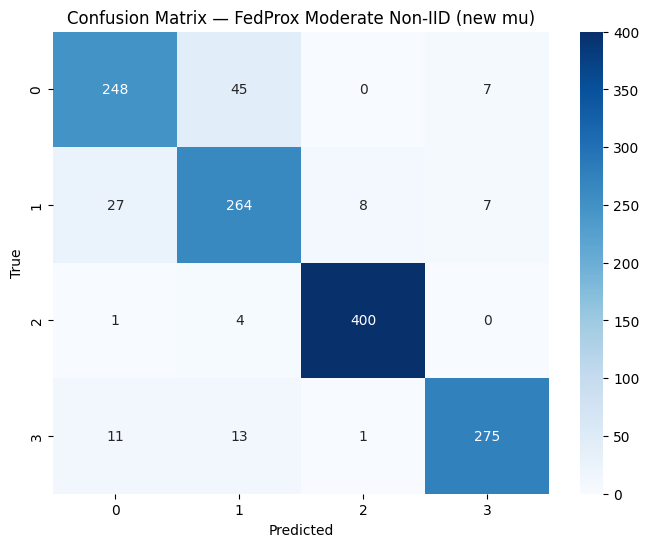

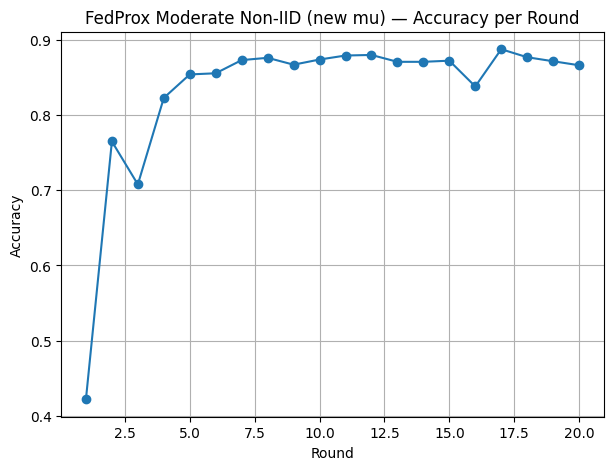

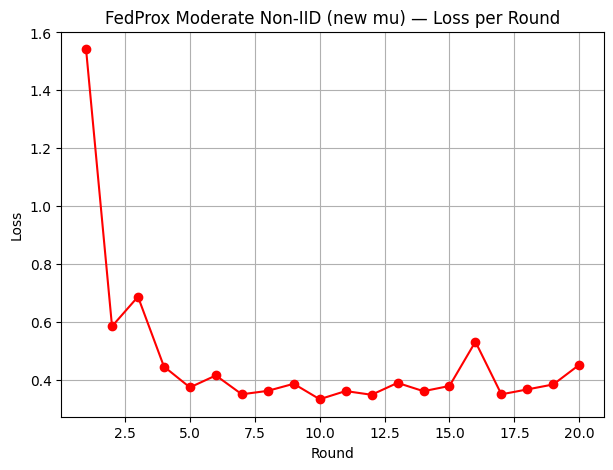

In [23]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np
from torchvision import models
import torch.nn as nn

# ===============================
# CONFIG
# ===============================
NUM_CLASSES_MOD = len(train_dataset.classes)

# ===============================
# MODEL DEF
# ===============================
def create_resnet18_mod(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ===============================
# LOAD BEST FEDPROX MODEL
# ===============================
best_model_prox = create_resnet18_mod(NUM_CLASSES_MOD)
best_model_prox.load_state_dict(torch.load("best_fedprox_moderate_noniid_newmu.pth", map_location=DEVICE))
best_model_prox.to(DEVICE)
best_model_prox.eval()

print("✅ Loaded best FedProx Moderate Non-IID model (new mu)!")

# ===============================
# EVALUATE ON HOLDOUT SET
# ===============================
all_preds = []
all_labels = []
total_loss = 0
total = 0

crit_ce = nn.CrossEntropyLoss()

with torch.no_grad():
    for x, y in holdout_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = best_model_prox(x)
        loss = crit_ce(logits, y)
        
        total_loss += loss.item() * x.size(0)
        total += x.size(0)
        preds = logits.argmax(1)

        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

acc = (all_preds == all_labels).mean()
precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)
loss = total_loss / total

print("\n📊 BEST FedProx Moderate Non-IID MODEL METRICS")
print(f"Accuracy : {acc:.4f}")
print(f"Loss     : {loss:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# ===============================
# CONFUSION MATRIX
# ===============================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix — FedProx Moderate Non-IID (new mu)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ===============================
# ROUND-WISE ACCURACY/LOSS PLOTS
# ===============================
rounds = metrics_history_mod["round"]
accs = [m["acc"] for m in metrics_history_mod["holdout"]]
losses = [m["loss"] for m in metrics_history_mod["holdout"]]

plt.figure(figsize=(7,5))
plt.plot(rounds, accs, marker="o")
plt.title("FedProx Moderate Non-IID (new mu) — Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(rounds, losses, marker="o", color="red")
plt.title("FedProx Moderate Non-IID (new mu) — Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Loading Moderate FedAvg model...
Loading Moderate FedProx (new mu) model...

========= MODERATE FEDAVG =========
Acc       : 0.8879
Loss      : 0.3488
Precision : 0.8818
Recall    : 0.8789
F1        : 0.8788

=== MODERATE FEDPROX (NEW MU) ====
Acc       : 0.9054
Loss      : 0.3330
Precision : 0.9009
Recall    : 0.8984
F1        : 0.8993


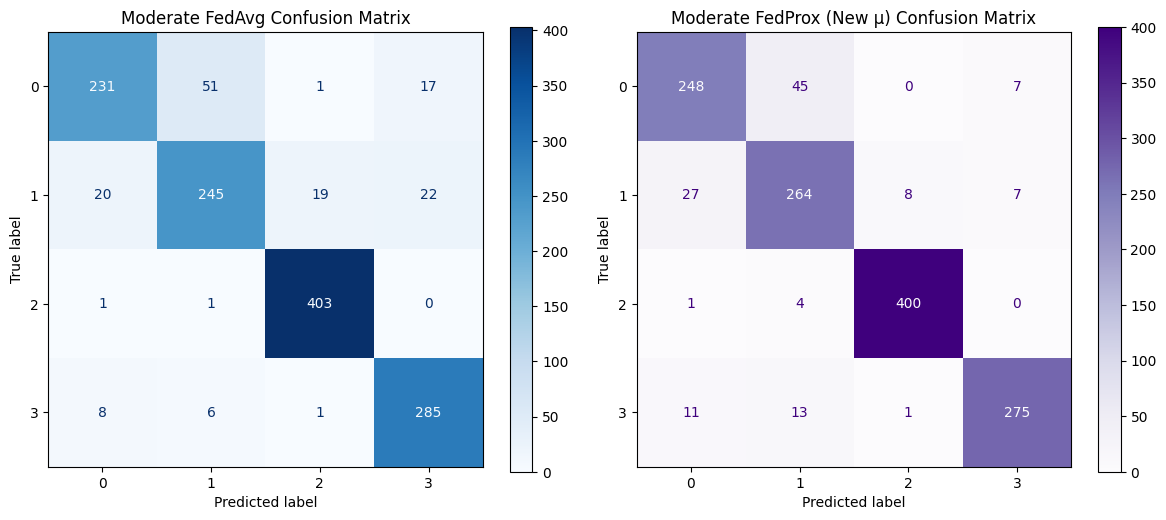

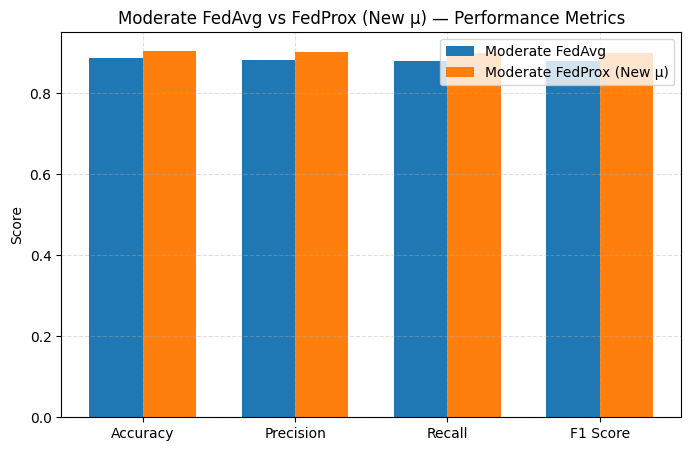

In [24]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import numpy as np
import torch.nn as nn
from torchvision import models

# ===============================
# CONFIG
# ===============================
NUM_CLASSES_MOD = len(train_dataset.classes)

# ===============================
# MODEL DEF
# ===============================
def create_resnet18_mod(num_classes):
    model = models.resnet18(weights=None)
    in_f = model.fc.in_features
    model.fc = nn.Linear(in_f, num_classes)
    return model

# ===============================
# LOAD THE TWO BEST MODELS
# ===============================
fedavg_mod_path = "best_fedavg_moderate_noniid.pth"
fedprox_mod_path = "best_fedprox_moderate_noniid_newmu.pth"

print("Loading Moderate FedAvg model...")
fedavg_mod_model = create_resnet18_mod(NUM_CLASSES_MOD).to(DEVICE)
fedavg_mod_model.load_state_dict(torch.load(fedavg_mod_path, map_location=DEVICE))
fedavg_mod_model.eval()

print("Loading Moderate FedProx (new mu) model...")
fedprox_mod_model = create_resnet18_mod(NUM_CLASSES_MOD).to(DEVICE)
fedprox_mod_model.load_state_dict(torch.load(fedprox_mod_path, map_location=DEVICE))
fedprox_mod_model.eval()

# ===============================
# COMMON EVALUATION FUNCTION
# ===============================
crit_ce = nn.CrossEntropyLoss()

def evaluate_full(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)

            logits = model(x)
            loss = crit_ce(logits, y)

            total_loss += loss.item() * x.size(0)
            total += x.size(0)

            preds = logits.argmax(1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    acc = (all_preds == all_labels).mean()
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    loss = total_loss / total

    return {
        "acc": acc,
        "loss": loss,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "preds": all_preds,
        "labels": all_labels
    }

# ===============================
# EVALUATE BOTH MODELS
# ===============================
fedavg_mod_metrics = evaluate_full(fedavg_mod_model, holdout_loader)
fedprox_mod_metrics = evaluate_full(fedprox_mod_model, holdout_loader)

# ===============================
# PRINT COMPARISON
# ===============================
print("\n========= MODERATE FEDAVG =========")
for k, v in fedavg_mod_metrics.items():
    if k not in ("preds", "labels"):
        print(f"{k.capitalize():10}: {v:.4f}")

print("\n=== MODERATE FEDPROX (NEW MU) ====")
for k, v in fedprox_mod_metrics.items():
    if k not in ("preds", "labels"):
        print(f"{k.capitalize():10}: {v:.4f}")

# ===============================
# PLOT CONFUSION MATRICES SIDE-BY-SIDE
# ===============================
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_avg = confusion_matrix(fedavg_mod_metrics["labels"], fedavg_mod_metrics["preds"])
cm_prox = confusion_matrix(fedprox_mod_metrics["labels"], fedprox_mod_metrics["preds"])

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_avg)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_prox)

disp1.plot(ax=axes[0], cmap="Blues", values_format="d")
disp2.plot(ax=axes[1], cmap="Purples", values_format="d")

axes[0].set_title("Moderate FedAvg Confusion Matrix")
axes[1].set_title("Moderate FedProx (New μ) Confusion Matrix")

plt.tight_layout()
plt.show()

# ===============================
# BAR PLOT FOR METRIC COMPARISON
# ===============================
labels = ["Accuracy", "Precision", "Recall", "F1 Score"]

fedavg_vals = [
    fedavg_mod_metrics["acc"],
    fedavg_mod_metrics["precision"],
    fedavg_mod_metrics["recall"],
    fedavg_mod_metrics["f1"]
]

fedprox_vals = [
    fedprox_mod_metrics["acc"],
    fedprox_mod_metrics["precision"],
    fedprox_mod_metrics["recall"],
    fedprox_mod_metrics["f1"]
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, fedavg_vals, width, label="Moderate FedAvg")
plt.bar(x + width/2, fedprox_vals, width, label="Moderate FedProx (New μ)")

plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Moderate FedAvg vs FedProx (New μ) — Performance Metrics")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()
